In [117]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import sympy as sp
import handcalcs.render
import forallpeople as si
import matplotlib.pyplot as plt
%matplotlib inline
from math import tan, sin,cos, pi, radians, sqrt, trunc
from IPython.display import display, Markdown
si.environment('structural', top_level=True)

<h2>Delta Beam verification</h2>

<h3>Compartment beneath: Office workspace</h3>

<img src='DELTA-Roof.png' style="width: 600px;"/>

<h4>Beam parameters</h4>

In [118]:
%%render param 2

L = 14.56*m
b = 500*mm
h = 500*mm
b1 = 130*mm
b2 = 330*mm
d2 = 30*mm
B = b+2*b1
phi = 150*mm
f_yk = 355*MPa
rho = 7850*kg/m**3
E_s20 = 210*GPa


<IPython.core.display.Latex object>

In [119]:
x = (B-2*b1-b2)/2

In [120]:
%%render 2

d_web = ((h-d2)**2+x**2)**0.5
d_web_net = d_web - phi
h_net = d_web_net+2*d2
A_botplate = d2*B
A_topplate = d2*b2
A_web = 2*d2*d_web_net

<IPython.core.display.Latex object>

Plastic section modulus: Area x distance from centroid to the plastic neutral axis (Area in tension = Area in compression)

In [121]:
%%render long 2

P_NA = (A_botplate-A_topplate+2*d2*h_net)/(4*d2)

<IPython.core.display.Latex object>

In [122]:
%%render symbolic

W_Pl = A_topplate*(P_NA-d2/2)+A_botplate*(h_net-d2/2-P_NA)+A_web*(P_NA-(d_web_net/2+d2))

<IPython.core.display.Latex object>

In [123]:
#another attempts to calculate wpl
#W_Pl2 = A_topplate*(P_NA-d2/2)+2*(A_web*(P_NA-d_web_net/2))+A_botplate*((h_net-d2/2)-P_NA)
#W_Pl3 = A_topplate*(P_NA-d2/2)+2*d2*(P_NA-d2)*((P_NA-d2)/2)+A_botplate*(h_net-P_NA-d2/2)+2*d2*(h_net-P_NA-d2)*((h_net-P_NA-d2)/2)

In [124]:
%%render 2
W_Pl
M_Pl = f_yk*W_Pl

<IPython.core.display.Latex object>

<h4>Loads</h4>

In [125]:
%%render param 2
psi_11 = 0.4
l_influence = 8.16*m
G_k = (3.88+1.64)*kN/m**2
Q_k = 0.8*kN/m**2
G_k_beam = 9.21*kN/m

<IPython.core.display.Latex object>

Load combination for fire:

In [148]:
%%render long 2

q_d = G_k*l_influence + G_k_beam + psi_11*Q_k*l_influence
M_max_ALS = q_d*L**2/8
mu_20 = M_max_ALS/M_Pl

<IPython.core.display.Latex object>

<h4>Compartment properties</h4>

In [127]:
%%render param 2

q = 200*10**6*J_m2
O = (0.02*m**0.5).prefix('unity')
b = 819.21*W*s**0.5*m**-2*K


<IPython.core.display.Latex object>

Steel deterioration constants Hot rolled bars 0.2% stress

In [128]:
%%render param 2
k = 0
T1 = 100000*dC
T2 = 100000*dC
T8 = 593*dC
T64 = 100000*dC



<IPython.core.display.Latex object>

In [129]:
from handcalcs import handcalc
@handcalc(jupyter_display = True)
def material_deterioration(T,k,T1,T2,T8,T64):
    """
    Calculate the deterioration of a material.
    """
    xi = k + (1-k)/(1+T/T1+(T/T2)**2+(T/T8)**8+(T/T64)**64)
    return xi


The critical temperature for the beam in which $\mu_{ALC} = \xi_{sH}$ is 550 $^{\circ }\textrm{C}$

In [130]:
T_cr = 550*dC
xi_sH = material_deterioration(T_cr,k,T1,T2,T8,T64)

<IPython.core.display.Latex object>

In [131]:
%%render 2
xi_sH

<IPython.core.display.Latex object>

In [132]:
%%render 2
mu_H = M_max_ALS/(M_Pl*xi_sH)

<IPython.core.display.Latex object>

The section factor of the insulation considers only the exposed area of the section, thus, the bottom plate.

In [133]:
%%render 2

SF = (B+2*d2)/(A_botplate+A_topplate+A_web)


<IPython.core.display.Latex object>

Thermal resistance of the intumescent paint with two coat Unitherm application (Pettersson)

In [134]:
%%render 3
TR = (0.064*m**2*dC/W)

<IPython.core.display.Latex object>

Specific heat capacity

In [135]:
def steel_cp(T):
    """
    Calculate the specific heat capacity of steel. For temperatures between 20 and 600 C.
    """
    return 425 + 7.73E-1*T -1.69E-3*T**2 + 2.22E-6*T**3


In [136]:
def gamma_f(O,b):
    return (O.value/0.04/(b.value/1160))**2

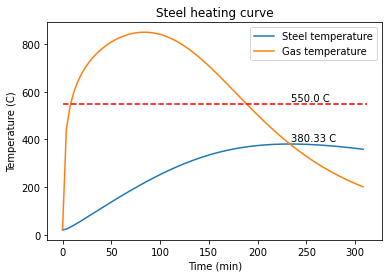

In [137]:
t_max = 0.0078*q.value/1E6/O.value
delta_t = t_max/20
t = np.arange(0,t_max*4,delta_t)
#create a dataframe with vector t
df = pd.DataFrame(t, columns=['t'])
#add a column with the temperature at each t
df['Tg'] = 20+345*np.log10(8*gamma_f(O,b)*df['t']+1)/(1+0.04*(df['t']/t_max)**3.5)
#add a column with the average from current and previous step T
df['Tg_avg'] = (df['Tg']+df['Tg'].shift(1))/2
#add a column called T_s with only temperature 20 in the first step
df['T_s'] = 20
for i in range(1,len(df)):
    df['T_s'][i] = df['T_s'][i-1]+1/(rho.value*steel_cp(df['T_s'][i-1]))*SF.value/TR.value*(df['Tg_avg'][i]-df['T_s'][i-1])*delta_t*60

#plot T_s and Tg
plt.plot(df['t'],df['T_s'],label='Steel temperature')
plt.plot(df['t'],df['Tg'],label='Gas temperature')
plt.legend()
plt.title('Steel heating curve')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (C)')
#plot dashed line with T_cr
plt.plot([0,t_max*4],[T_cr.value,T_cr.value],linestyle='--',color='red')
#show max T_s
plt.text(df['t'][df['T_s'].idxmax()],df['T_s'].max()+10,str(round(df['T_s'].max(),2))+' C')
#show T_cr
plt.text(df['t'][df['T_s'].idxmax()],T_cr.value+10,str(round(T_cr.value,2))+' C')


plt.show()




The design is too conservative since the temperature reached is almost 200 degrees below the critical level. In order to test whether the section can be verified without applying an insulation layer, an **uninsulated steel heating** verification will be performed. This approach is only reasonable due to the low exposure (only the bottom flange) of the delta section to fire.

**Uninsolated verification**

In [138]:
def res_emiss(egas, esteel):
    er = 1/(egas**-1+esteel**-1-1)
    return er

In [139]:
egas = 0.85
esteel = 0.8
er = res_emiss(egas, esteel)

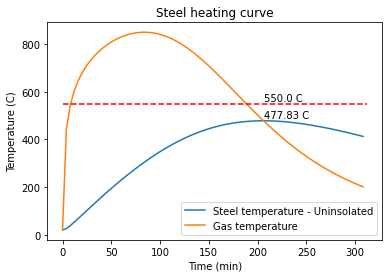

In [140]:
t_max = 0.0078*q.value/1E6/O.value
delta_t = t_max/20
t = np.arange(0,t_max*4,delta_t)
#create a dataframe with vector t
df = pd.DataFrame(t, columns=['t'])
#add a column with the temperature at each t
df['Tg'] = 20+345*np.log10(8*gamma_f(O,b)*df['t']+1)/(1+0.04*(df['t']/t_max)**3.5)
#add a column with the average from current and previous step T
df['Tg_avg'] = (df['Tg']+df['Tg'].shift(1))/2
#add a column called T_s with only temperature 20 in the first step
df['T_s'] = 20
for i in range(1,len(df)):
    df['T_s'][i] = df['T_s'][i-1]+(25+5.6704*10**-8*er*(df['Tg_avg'][i]**4-df['T_s'][i-1]**4)/(df['Tg_avg'][i]-df['T_s'][i-1]**4))/(rho.value*steel_cp(df['T_s'][i-1]))*SF.value*(df['Tg_avg'][i]-df['T_s'][i-1])*delta_t*60
#plot T_s and Tg
plt.plot(df['t'],df['T_s'],label='Steel temperature - Uninsolated')
plt.plot(df['t'],df['Tg'],label='Gas temperature')
plt.legend()
plt.title('Steel heating curve')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (C)')
#plot dashed line with T_cr
plt.plot([0,t_max*4],[T_cr.value,T_cr.value],linestyle='--',color='red')
#show max T_s
plt.text(df['t'][df['T_s'].idxmax()],df['T_s'].max()+10,str(round(df['T_s'].max(),2))+' C')
#show T_cr
plt.text(df['t'][df['T_s'].idxmax()],T_cr.value+10,str(round(T_cr.value,2))+' C')


plt.show()

With gypsum plaster insulation

In [141]:
def gyp_conductivity(T):
    if T<200:
        c = 0.210
    elif T<300:
        c = 0.140
    elif T<400:
        c = 0.157
    elif T<500:
        c = 0.181
    elif T<600:
        c = 0.198
    else:
        c= 0.220
    return c

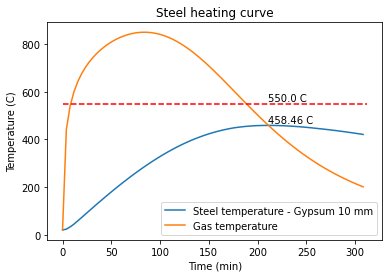

In [142]:
d_ins = 10*mm
A_ins = (d2+d_ins)*2+(B+2*d_ins)
SF_ins = A_ins/(A_botplate+A_topplate+A_web)
t_max = 0.0078*q.value/1E6/O.value
delta_t = t_max/20
t = np.arange(0,t_max*4,delta_t)
#create a dataframe with vector t
df = pd.DataFrame(t, columns=['t'])
#add a column with the temperature at each t
df['Tg'] = 20+345*np.log10(8*gamma_f(O,b)*df['t']+1)/(1+0.04*(df['t']/t_max)**3.5)
#add a column with the average from current and previous step T
df['Tg_avg'] = (df['Tg']+df['Tg'].shift(1))/2
#add a column called T_s with only temperature 20 in the first step
df['T_s'] = 20
for i in range(1,len(df)):
    df['T_s'][i] = df['T_s'][i-1]+1/(rho.value*steel_cp(df['T_s'][i-1]))*SF_ins.value*gyp_conductivity(df['Tg_avg'][i])/d_ins.value*(df['Tg_avg'][i]-df['T_s'][i-1])*delta_t*60

#plot T_s and Tg
plt.plot(df['t'],df['T_s'],label='Steel temperature - Gypsum 10 mm')
plt.plot(df['t'],df['Tg'],label='Gas temperature')
plt.legend()
plt.title('Steel heating curve')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (C)')
#plot dashed line with T_cr
plt.plot([0,t_max*4],[T_cr.value,T_cr.value],linestyle='--',color='red')
#show max T_s
plt.text(df['t'][df['T_s'].idxmax()],df['T_s'].max()+10,str(round(df['T_s'].max(),2))+' C')
#show T_cr
plt.text(df['t'][df['T_s'].idxmax()],T_cr.value+10,str(round(T_cr.value,2))+' C')


plt.show()

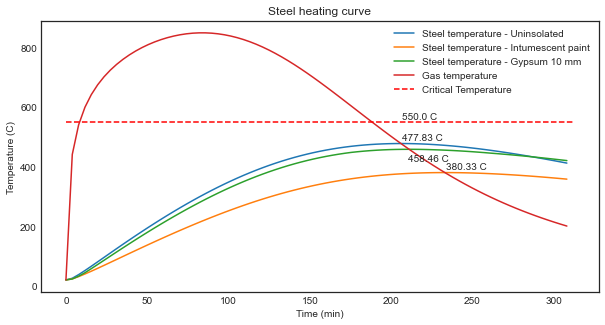

In [147]:
d_ins = 10*mm
A_ins = (d2+d_ins)*2+(B+2*d_ins)
SF_ins = A_ins/(A_botplate+A_topplate+A_web)
t_max = 0.0078*q.value/1E6/O.value
delta_t = t_max/20
t = np.arange(0,t_max*4,delta_t)
#create a dataframe with vector t
df = pd.DataFrame(t, columns=['t'])
#add a column with the temperature at each t
df['Tg'] = 20+345*np.log10(8*gamma_f(O,b)*df['t']+1)/(1+0.04*(df['t']/t_max)**3.5)
#add a column with the average from current and previous step T
df['Tg_avg'] = (df['Tg']+df['Tg'].shift(1))/2
#add a column called T_s with only temperature 20 in the first step
df['T_s_ip'] = 20
df['T_s'] = 20
df['T_s_gy'] = 20
for i in range(1,len(df)):
    df['T_s_ip'][i] = df['T_s_ip'][i-1]+1/(rho.value*steel_cp(df['T_s_ip'][i-1]))*SF.value/TR.value*(df['Tg_avg'][i]-df['T_s_ip'][i-1])*delta_t*60
    df['T_s'][i] = df['T_s'][i-1]+(25+5.6704*10**-8*er*(df['Tg_avg'][i]**4-df['T_s'][i-1]**4)/(df['Tg_avg'][i]-df['T_s'][i-1]**4))/(rho.value*steel_cp(df['T_s'][i-1]))*SF.value*(df['Tg_avg'][i]-df['T_s'][i-1])*delta_t*60
    df['T_s_gy'][i] = df['T_s_gy'][i-1]+1/(rho.value*steel_cp(df['T_s_gy'][i-1]))*SF_ins.value*gyp_conductivity(df['Tg_avg'][i])/d_ins.value*(df['Tg_avg'][i]-df['T_s_gy'][i-1])*delta_t*60

#plot T_s and Tg
plt.figure(figsize=(10,5))
plt.style.use('seaborn-white')
plt.plot(df['t'],df['T_s'],label='Steel temperature - Uninsolated')
plt.plot(df['t'],df['T_s_ip'],label='Steel temperature - Intumescent paint')
plt.plot(df['t'],df['T_s_gy'],label='Steel temperature - Gypsum 10 mm')
plt.plot(df['t'],df['Tg'],label='Gas temperature')
plt.title('Steel heating curve')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (C)')
#plot dashed line with T_cr
plt.plot([0,t_max*4],[T_cr.value,T_cr.value],linestyle='--',color='red', label='Critical Temperature')
plt.legend()
#show max T_s
plt.text(df['t'][df['T_s'].idxmax()],df['T_s'].max()+10,str(round(df['T_s'].max(),2))+' C')
#show max T_s_ip
plt.text(df['t'][df['T_s_ip'].idxmax()],df['T_s_ip'].max()+10,str(round(df['T_s_ip'].max(),2))+' C')
#show max T_s_gy
plt.text(df['t'][df['T_s_gy'].idxmax()],df['T_s_gy'].max()-40,str(round(df['T_s_gy'].max(),2))+' C')
#show T_cr
plt.text(df['t'][df['T_s'].idxmax()],T_cr.value+10,str(round(T_cr.value,2))+' C')


plt.show()